### Loading the required libraries

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from surprise import Reader
from surprise import Dataset
from surprise.model_selection import train_test_split
from surprise import KNNWithMeans
from surprise import accuracy

### Loading the dataset (Meet the data)

In [56]:
# Reading the dataset (CSV file)
csv_file_path = r'datasets_src\\Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv'
selected_cols_list = ['name', 'asins', 'reviews.rating', 'reviews.username']
df = pd.read_csv(csv_file_path, usecols=selected_cols_list, encoding='utf8' ,low_memory=False)
# Rename the selected cols 
df.columns = ['product_name', 'product_id', 'rating', 'user']

In [57]:
# Preview the first five rows of the dataset
df.head()

,product_name,product_id,rating,user
0,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,3,llyyue
1,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,5,Charmi
2,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,4,johnnyjojojo
3,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,5,Kdperry
4,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,5,Johnnyblack


### Exploratory data analysis (EDA)

In [58]:
# Preview the shape of the dataset
df.shape

(5000, 4)

In [59]:
# Preview the columns of the dataset
df.columns

Index(['product_name', 'product_id', 'rating', 'user'], dtype='object')

In [60]:
# Preview the data types of the columns
df.dtypes

product_name    object
product_id      object
rating           int64
user            object
dtype: object

In [61]:
df.describe()

,rating
count,5000.000000
mean,4.596800
std,0.731804
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [ ]:
df['rating'].value_counts()

#### Calculating rating counts - Bar Chart

In [65]:
ratings_count = pd.DataFrame(df['rating'].value_counts()).reset_index()
ratings_count.columns = ['rating', 'count']
ratings_count

,rating,count
0,5,3478
1,4,1208
2,3,197
3,1,63
4,2,54


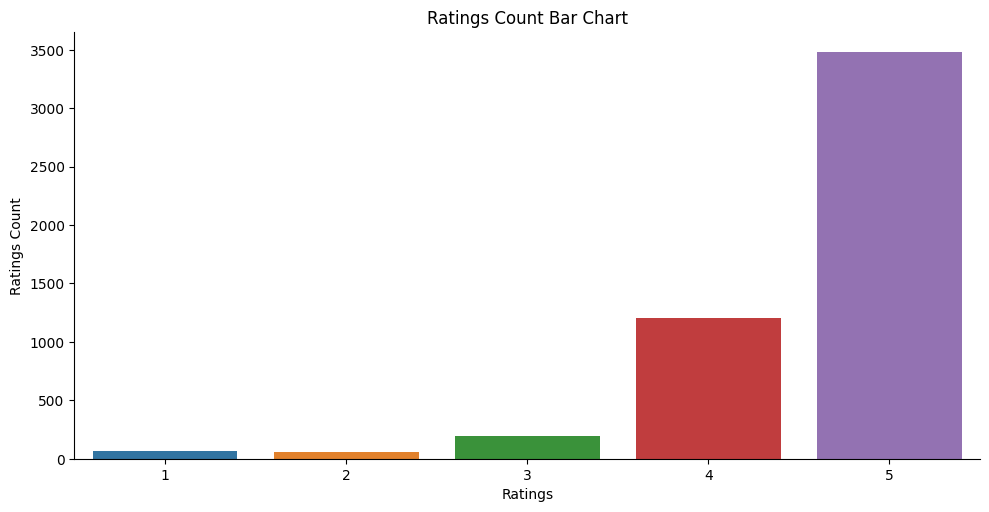

In [70]:
chart_bar = sns.catplot(x="rating", data=df, kind="count", aspect=2)
chart_bar.set_xlabels("Ratings")
chart_bar.set_ylabels("Ratings Count")

plt.title('Ratings Count Bar Chart')
plt.show()

### Collaborative Filtering (Item-Item Recommendation)

#### Selecting features to use

In [78]:
# To select user_items ratings
cf_data = df[['user', 'product_id', 'rating']]
cf_data.head()

,user,product_id,rating
0,llyyue,B00ZV9PXP2,3
1,Charmi,B00ZV9PXP2,5
2,johnnyjojojo,B00ZV9PXP2,4
3,Kdperry,B00ZV9PXP2,5
4,Johnnyblack,B00ZV9PXP2,5


In [79]:
reader = Reader(rating_scale=(1, 5))

cf_data = Dataset.load_from_df(cf_data, reader)
train_data, test_data = train_test_split(cf_data, test_size=0.3, random_state=10)

#### Calculating Similarity - Model

In [82]:
# Calculating Similarity
knn = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False}, verbose=False)
knn.fit(train_data)

predictions = knn.test(test_data)

In [83]:
# Function to return number of items rated by given user
def get_Iu(uid):
    try:
        return len(train_data.ur[train_data.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
# return number of users that have rated given item
def get_Ui(iid):
    try: 
        return len(train_data.ir[train_data.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

#### Model Evaluation

In [84]:
best_predictions = df.sort_values(by='err')[:10]
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
847,Rick,B01AHBBG04,5.0,5.0,"{'actual_k': 3, 'was_impossible': False}",8,30,0.0
917,st2005,B017JG41PC,5.0,5.0,"{'actual_k': 2, 'was_impossible': False}",2,110,0.0
1342,Lori,B01AHB9CYG,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",2,29,0.0
155,Amanda,B06XB29FPF,5.0,5.0,"{'actual_k': 2, 'was_impossible': False}",2,433,0.0
1340,JLT421,B00REQKWGA,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",1,25,0.0
811,kimb,B018Y22BI4,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",1,258,0.0
916,Tony,B00IOY8XWQ,5.0,5.0,"{'actual_k': 2, 'was_impossible': False}",5,54,0.0
163,yokod,B018Y225IA,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",1,343,0.0
646,Ipadjunkie,B018Y225IA,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",1,343,0.0
814,KiKi,B018Y22C2Y,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",2,390,0.0


In [85]:
worst_predictions = df.sort_values(by='err')[-10:]
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
1127,floridapete,B00IOY8XWQ,1.0,4.608571,"{'was_impossible': True, 'reason': 'User and/o...",0,54,3.608571
1087,tiger,B01AHB9CN2,1.0,4.608571,"{'was_impossible': True, 'reason': 'User and/o...",0,545,3.608571
433,Jinn,B018Y22C2Y,1.0,4.608571,"{'was_impossible': True, 'reason': 'User and/o...",0,390,3.608571
561,Sathya,B018Y22BI4,1.0,4.608571,"{'was_impossible': True, 'reason': 'User and/o...",0,258,3.608571
1187,Jorge6541,B018Y22C2Y,1.0,4.608571,"{'was_impossible': True, 'reason': 'User and/o...",0,390,3.608571
1435,Ronny,B018Y22BI4,1.0,4.608571,"{'was_impossible': True, 'reason': 'User and/o...",0,258,3.608571
131,AmyLeigh,B018Y22BI4,1.0,4.608571,"{'was_impossible': True, 'reason': 'User and/o...",0,258,3.608571
1376,HDelbrucke,B01AHB9CN2,1.0,4.608571,"{'was_impossible': True, 'reason': 'User and/o...",0,545,3.608571
1120,Kev,B00ZV9PXP2,1.0,4.608571,"{'was_impossible': True, 'reason': 'User and/o...",0,70,3.608571
1401,1985Taetx16,B018Y22C2Y,1.0,4.608571,"{'was_impossible': True, 'reason': 'User and/o...",0,390,3.608571


In [87]:
accuracy.rmse(predictions, verbose=True)

RMSE: 0.6911


0.6910659357405085